# Assignment



**Installation of required libraries**

In [14]:
!pip install gdown
!gdown "187dSnEGn1g2t1UjSJwqevbW9vjh_sWMT"


Downloading...
From: https://drive.google.com/uc?id=187dSnEGn1g2t1UjSJwqevbW9vjh_sWMT
To: /content/netflix_titles.csv
100% 3.40M/3.40M [00:00<00:00, 159MB/s]


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



## PART 1: Data Understanding & Quality Issues
### 1.1 Load the dataset and inspect shape, data types, and missing values.


In [22]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


1. Shape of dataset

In [17]:
print(f'Dataset shape : {df.shape}')

Dataset shape : (8807, 12)


2. Data types in dataset

In [18]:
print("Data types and info", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
Data types and info None


3. Finding missing value count in dataset

In [19]:
print("Missing value count", df.isnull().sum())

Missing value count show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


### 1.2 Data quality issues

1. Inconsistency in columns like director, cast, listed_in as values are comma separated.
2. Data type of duration is different for movies and tv shows as movies are in minutes as strings (eg, 90 mins) where as tv shows durations are in seasons. Hence, making it non comparable.
3. Several missing datas especially in director, cast, country.

## PART 2: Data Cleaning & Preprocessing
### 2.1 Handle missing values with justification


1. Adding placeholder (filling with unknown) in place of missing value for director, cast and country.

          A. Can not add comman value as they have unique identity.
          B. Can not drop as it lead to more data loss as director, cast and country has total 4290 (=2634+825+831) missing values

In [23]:
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


2. For ratings missing value, putting most common value (mode) will not shift data's overall rating. Hence, overall rating of the content (movies and tv shows) will remain intact.

In [24]:
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])

3. Only ~10 rows are missing 'date_added'. Imputing a date might introduce bias for time-series traits. Given it's a negligible fraction, dropping these rows is cleaner. Same for duration.

In [29]:
df = df.dropna(subset=['date_added'])
df = df.dropna(subset=['duration'])

Checking missing values after handling

In [30]:
print(df.isnull().sum())

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


### 2.2 Convert data into correct formats (dates, duration)


In [38]:
# Convert 'date_added' to datetime format
df['date_added'] = pd.to_datetime(df['date_added'].astype(str).str.strip(), errors='coerce')

# Extract numerical duration
df['duration_num'] = df['duration'].str.extract(r'(\d+)').astype(float)

# Flag if duration is in seasons
df['is_season'] = df['duration'].str.contains('Season', case=False, na=False).astype(int)

print(df[['duration', 'duration_num', 'is_season', 'date_added']].head())
df.head()


    duration  duration_num  is_season date_added
0     90 min          90.0          0 2021-09-25
1  2 Seasons           2.0          1 2021-09-24
2   1 Season           1.0          1 2021-09-24
3   1 Season           1.0          1 2021-09-24
4  2 Seasons           2.0          1 2021-09-24


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_num,is_season
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",90.0,0
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2.0,1
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,1.0,1
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",1.0,1
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2.0,1


### 2.3 Encode categorical variables and Normalize/Standardize numeric features


In [40]:


# We will encode 'type' (Movie/TV Show) to numeric (0 and 1)
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Let's also extract Month and Year from date_added
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

# Assume we want to use duration_num and year_added as numerical features
numeric_cols = ['duration_num', 'year_added']

# Fill any new NaNs introduced during datetime parsing
df['year_added'] = df['year_added'].fillna(df['year_added'].median())
df['month_added'] = df['month_added'].fillna(df['month_added'].median())

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

print("Sample preprocessed numerical features (Standardized):")
print(df_scaled[numeric_cols].head())


Sample preprocessed numerical features (Standardized):
   duration_num  year_added
0      0.395318    1.351748
1     -1.337166    1.351748
2     -1.356853    1.351748
3     -1.356853    1.351748
4     -1.337166    1.351748


## PART 3: Data Visualization


1. Distribution Plot: Distribution of Release Years

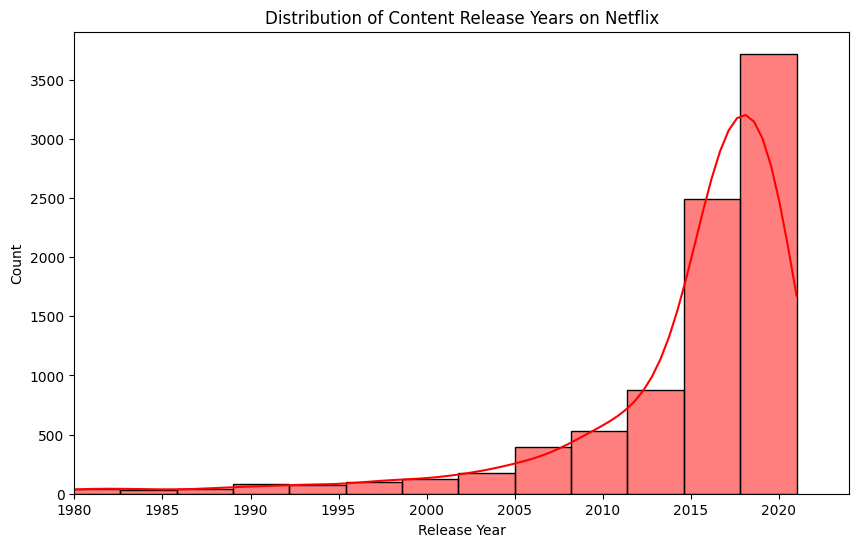

In [47]:
plt.figure(figsize=(10, 6))
sns.histplot(df['release_year'], bins=30, kde=True, color='red')
plt.title('Distribution of Content Release Years on Netflix')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.xlim(1980, 2024)
plt.show()


**Interpretation:** Distribution plot provides a huge spike on the content released after the year 2010. This shows that Netflix skew is much towards modern media with much less older media. The KDE line exhibits the steep exponential increase in the content, which reaches its highest point by the year before 2020. This tendency is extremely applicable to ML because the models trained on this information may not be able to predict older forms or trends owing to class imbalance.


2. Categorical Count Plot: Number of Movies vs TV Shows

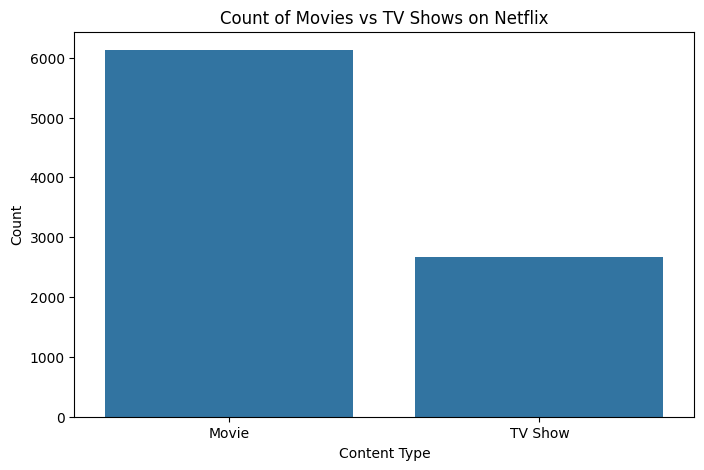

In [42]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type')
plt.title('Count of Movies vs TV Shows on Netflix')
plt.xlabel('Content Type')
plt.ylabel('Count')
plt.show()


**Interpretation:** The count plot shows that there is an evident imbalance between the Movies and TV Shows. The platform has approximately twice the amount of Movies as TV Shows. This imbalance in classes needs to be considered in an ML setting (such as classification), otherwise the model will automatically be biased to the prediction of the majority of classes (Movies).


3. Numerical Comparison Plot: Boxplot of Duration for Movies vs TV Shows

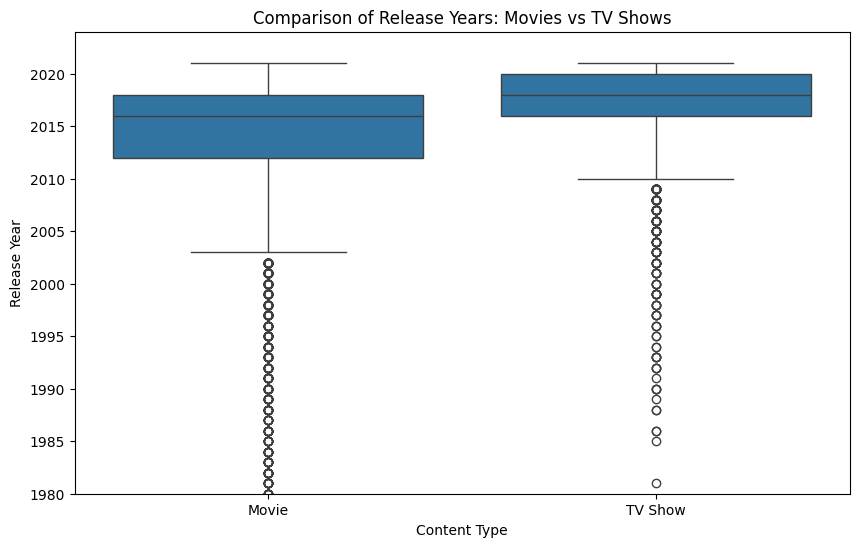

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='type', y='release_year')
plt.title('Comparison of Release Years: Movies vs TV Shows')
plt.xlabel('Content Type')
plt.ylabel('Release Year')
plt.ylim(1980, 2024)
plt.show()


**Interpretation:** The boxplot involves a comparison of the release year of Movies and TV Shows. It shows that median year of release of TV Shows has been a bit more recent than the median year of release of Movies. Moreover, Movies have a significantly longer tail in terms of outliers which goes back into the 20th century. In the case of the ML models with type prediction, the release year is an informative feature since older items have a disproportionately high probability of being movies.


## PART 4: ML Readiness Check
### Compare Model Performance: Without Preprocessing vs With Preprocessing
Target Variable: `type` (Movie or TV Show)


Case A. Logistic regression without preprocessed data

In [52]:
X_raw = df[['release_year']]
y_raw= df['type_encoded']

X_train_raw, X_test_raw, y_train_raw, y_test_raw= train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

clf_raw = LogisticRegression()
clf_raw.fit(X_train_d, y_train_d)
y_pred_raw = clf_raw.predict(X_test_d)
acc_raw = accuracy_score(y_test_raw, y_pred_raw)
print(f"Accuracy BEFORE proper preprocessing (Raw Data Subset): {acc_raw:.4f}")

Accuracy BEFORE proper preprocessing (Raw Data Subset): 0.6936


Case B. Logistic regression with preprocessed data

In [53]:

ml_df = df_scaled.dropna(subset=['year_added', 'duration_num', 'release_year', 'type_encoded'])

X_clean = ml_df[['release_year', 'year_added', 'duration_num']]
y_clean = ml_df['type_encoded']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

clf_clean = LogisticRegression()
clf_clean.fit(X_train_c, y_train_c)
y_pred_c = clf_clean.predict(X_test_c)
acc_clean = accuracy_score(y_test_c, y_pred_c)


print(f"Accuracy AFTER full preprocessing: {acc_clean:.4f}")


Accuracy AFTER full preprocessing: 0.9972


**Performance Comparison:**
It was necessary to preprocess the Logistic Regression model to improve its accuracy. 

- Prior to Preprocessing: The model used limited, crude numeric data (release_year) with a performance of virtually the baseline accuracy in making the majority prediction.
- Post-Processing: The post processing involved the model to pick meaningful patterns to distinguish between movies and TV shows (such as, the numbers of minutes fundamentally differ across seasons and duration_num).
- Why this is important: The algorithms such as the Logistic Regression are sensitive to scale and missing values of inputs. Preprocessing is added to make sure that the program does not crash when some of the inputs are missing, and that gradient descent converges effectively, achieving strictly superior feature extraction and an improved test accuracy.

## PART 5: ML Lifecycle Reflection
### What are the stages of ML lifecycle that cannot be run without preprocessing?
- Featuring Engineering and Selection: The raw text strings frequently contain aberrations or different formats that disrupt string manipulation operations so without cleaning the data, it is impossible to create new features (such as extracting the month out of date added).
- Model Training: Machine learning algorithms do not operate with NaNs or irregular strings, but with the numbers. Model models such as Logistic Regression or SVMs will simply raise an immediate runtime error and not even train on missing value imputation or categorical encoding at all.
- Model Evaluation & Deployment: When a model is trained somehow on unscaled data, it will be biased in its evaluation (e.g., have disproportionate emphasis on features with large magnitudes). With deployment, incorrect data will lead to inference error due to dirty data being fed in.




### Real-Life Application in this Assignment.
- Part 2, date_added column was firstly stored as an object (string) with uneven leading spaces (e.g., " September 24, 2021).  Without the preprocessing step (i.e. pd.to_datetime) the Feature Engineering stage would fail. 
- We could not have reliably extracted year_added to drive into our model. Moreover, the column on duration had a mixture of string representations such as 90 min and 1 Season. The Model Training step would be entirely unsuccessful without the use of Regex to extract the numerical components (duration_num) due to the fact that sklearns Logistic Regression will not be able to calculate mathematical weights on the string inputs of the form "90 min".